In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import backend
from transformers import TFSegformerForSemanticSegmentation
import numpy as np
import random
import os

def set_global_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For CPU/GPU determinism (depending on TF version & GPU model):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_global_seed(seed=42)

2024-12-16 18:06:44.109925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 18:06:45.182143: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-12-16 18:06:45.182254: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or di

In [2]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

image_size = 128
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


# def normalize(input_image, input_mask):
#     input_image = tf.image.convert_image_dtype(input_image, tf.float32)
#     input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
#     input_mask -= 1
#     return input_image, input_mask

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

auto = tf.data.AUTOTUNE
batch_size = 4

train_ds = (
    dataset["train"]
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto) 
    .batch(batch_size)
    .prefetch(auto)
)

test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    output_hidden_states=True  
)

model.config.upsample_align_corners = True

lr = 0.00006
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

epochs = 40

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, monitor="val_loss", restore_best_weights=True),
]

model.build(input_shape=(None, 3, image_size, image_size))

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=callbacks
)

2024-12-16 18:06:48.735793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 18:06:48.747966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 18:06:48.749593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 18:06:48.751972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/40
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2024-12-16 18:07:21.242599: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape intf_segformer_for_semantic_segmentation/decode_head/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-16 18:07:25.401879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


132/920 [===>..........................] - ETA: 46s - loss: 0.5992

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


920/920 [==============================] - 141s 102ms/step - loss: 0.3692 - val_loss: 0.2650
Epoch 2/40
920/920 [==============================] - 80s 87ms/step - loss: 0.2675 - val_loss: 0.2546
Epoch 3/40
920/920 [==============================] - 79s 86ms/step - loss: 0.2357 - val_loss: 0.2445
Epoch 4/40
920/920 [==============================] - 86s 93ms/step - loss: 0.2198 - val_loss: 0.3261
Epoch 5/40
920/920 [==============================] - 78s 85ms/step - loss: 0.2078 - val_loss: 0.2344
Epoch 6/40
920/920 [==============================] - 78s 85ms/step - loss: 0.1962 - val_loss: 0.2383
Epoch 7/40
920/920 [==============================] - 84s 92ms/step - loss: 0.1852 - val_loss: 0.2355
Epoch 8/40
920/920 [==============================] - 78s 85ms/step - loss: 0.1783 - val_loss: 0.2384
Epoch 9/40
920/920 [==============================] - 77s 84ms/step - loss: 0.1805 - val_loss: 0.2765


In [9]:
model.evaluate(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


918/918 [==============================] - 33s 26ms/step - loss: 0.2344


0.23439936339855194

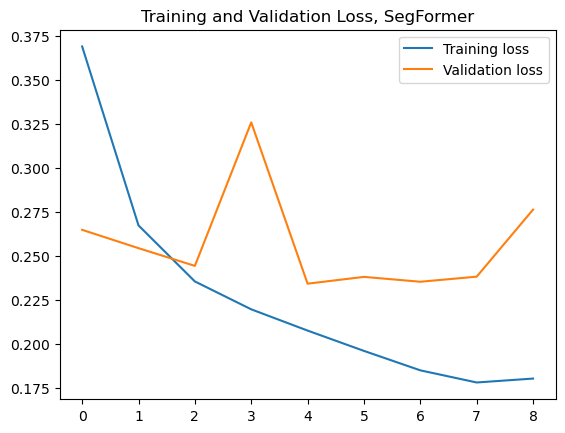

In [4]:
import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.to_csv("/mnt/disks/saliency/segformer_fine_tune_pets_history.csv", index=False)

import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Training and Validation Loss, SegFormer")
plt.legend()
plt.show()


In [11]:
original_image_size = (image_size, image_size)
predictions = []
ground_truths = []

for batch in test_ds:
    # Extract the inputs and ground truth labels
    pixel_values = batch["pixel_values"]
    labels = batch["labels"]
    
    # Forward pass through the model
    outputs = model(pixel_values, training=False)
    # outputs.logits shape is [batch_size, num_labels, height', width']

    # Convert to predicted class IDs
    pred_mask = tf.argmax(outputs.logits, axis=1)  # shape: [batch_size, height', width']
    
    # Resize the predicted mask back to original size
    pred_mask_resized = tf.image.resize(
        tf.expand_dims(pred_mask, axis=-1), # [batch_size, height', width', 1]
        size=original_image_size,
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    pred_mask_resized = tf.squeeze(pred_mask_resized, axis=-1)  # [batch_size, height, width]
    
    # Collect results
    predictions.append(pred_mask_resized)
    ground_truths.append(labels) 

In [12]:
predictions = tf.concat(predictions, axis=0)  
ground_truths = tf.concat(ground_truths, axis=0)

num_classes = len(id2label) 

# Compute confusion matrix
cm = tf.math.confusion_matrix(
    tf.reshape(ground_truths, [-1]),
    tf.reshape(predictions, [-1]),
    num_classes=num_classes
)

# Compute IoU from the confusion matrix
sum_over_row = tf.reduce_sum(cm, axis=0)
sum_over_col = tf.reduce_sum(cm, axis=1)
true_positives = tf.linalg.diag_part(cm)
denominator = sum_over_row + sum_over_col - true_positives
iou = true_positives / denominator
mean_iou = tf.reduce_mean(iou)

print("Mean IoU:", mean_iou.numpy())

Mean IoU: 0.7369081562292051


In [13]:
ground_truths = tf.cast(ground_truths, tf.int64)
correct = tf.reduce_sum(tf.cast(tf.equal(predictions, ground_truths), tf.float32))
total = tf.size(predictions, out_type=tf.float32)
accuracy = correct / total
print("Accuracy:", accuracy.numpy())

Accuracy: 0.90317386


In [8]:
model.save_pretrained("/mnt/disks/saliency/segformer_fine_tune_pets")

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import backend
from transformers import TFSegformerForSemanticSegmentation
import numpy as np
import random
import os

def set_global_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # For CPU/GPU determinism (depending on TF version & GPU model):
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_global_seed(seed=42)

2024-12-16 23:49:30.831838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-16 23:49:32.130863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-12-16 23:49:32.131013: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or di

In [2]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

image_size = 128
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )

    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

auto = tf.data.AUTOTUNE
batch_size = 4

train_ds = (
    dataset["train"]
    .cache()
    .shuffle(batch_size * 10)
    .map(load_image, num_parallel_calls=auto) 
    .batch(batch_size)
    .prefetch(auto)
)

test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=auto)
    .batch(batch_size)
    .prefetch(auto)
)

model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2: "border"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = TFSegformerForSemanticSegmentation.from_pretrained("/mnt/disks/saliency/segformer_fine_tune_pets")


2024-12-16 23:49:37.202396: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 23:49:37.257589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 23:49:37.259235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-16 23:49:37.261397: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at /mnt/disks/saliency/segformer_fine_tune_pets.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


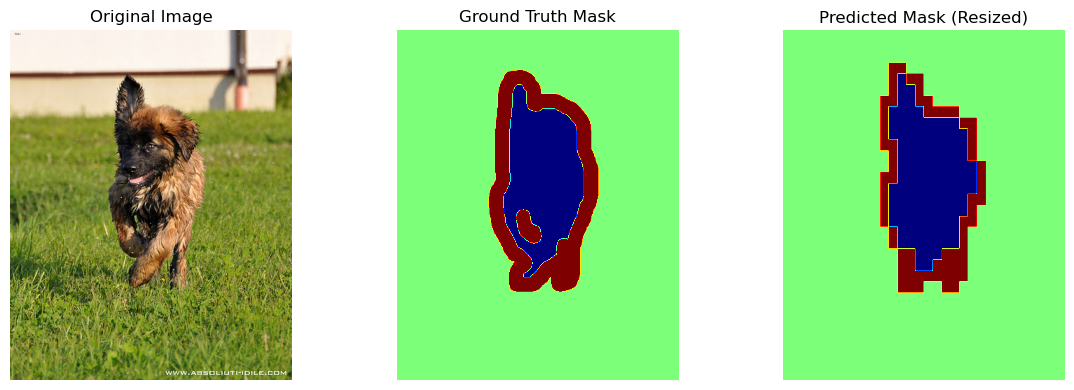

In [25]:
import matplotlib.pyplot as plt
test_sample = next(iter(dataset["test"].take(1)))

original_image = test_sample["image"]  # shape: (orig_h, orig_w, 3)
original_mask = test_sample["segmentation_mask"]  # shape: (orig_h, orig_w, 1)
original_size = tf.shape(original_image)[:2]  # (orig_h, orig_w)

def preprocess_image(image):
    image = tf.image.resize(image, (image_size, image_size))
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.transpose(image, (2, 0, 1))  # [3, image_size, image_size]
    return image

# Preprocess image for the loaded model
input_image_preprocessed = preprocess_image(original_image)
input_batch = tf.expand_dims(input_image_preprocessed, axis=0)  # shape: [1, 3, image_size, image_size]

# Run inference
outputs = model(input_batch)
logits = outputs.logits  # shape: [1, num_labels, image_size, image_size]
pred_mask = tf.argmax(logits, axis=1)  # shape: [1, image_size, image_size]

# Resize predicted mask back to original size
pred_mask_4d = tf.expand_dims(pred_mask, axis=-1)  # [1, image_size, image_size, 1]
pred_mask_resized = tf.image.resize(
    pred_mask_4d,
    size=original_size, 
    method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
)  # [1, orig_h, orig_w, 1]
pred_mask_resized = tf.squeeze(pred_mask_resized, axis=[0, -1])  # [orig_h, orig_w]

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(original_image.numpy().astype("uint8"))
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(tf.squeeze(original_mask, axis=-1), cmap="jet")
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

axes[2].imshow(pred_mask_resized.numpy(), cmap="jet")
axes[2].set_title("Predicted Mask (Resized)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [8]:
model.config.upsample_align_corners = True

lr = 0.00006
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

(-0.5, 402.5, 499.5, -0.5)

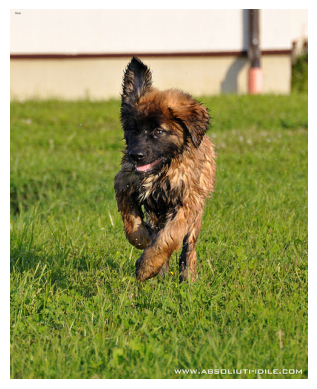

In [15]:
#
plt.imshow(original_image.numpy().astype("uint8"))
plt.axis("off")


(-0.5, 402.5, 499.5, -0.5)

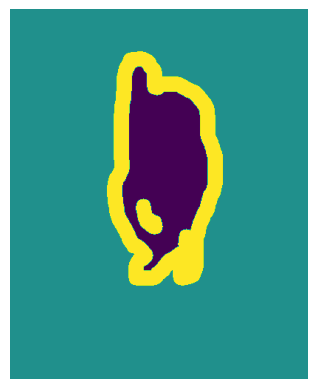

In [16]:
plt.imshow(tf.squeeze(original_mask, axis=-1))
plt.axis("off")
#axes[1].imshow(tf.squeeze(original_mask, axis=-1), cmap="jet")

(-0.5, 402.5, 499.5, -0.5)

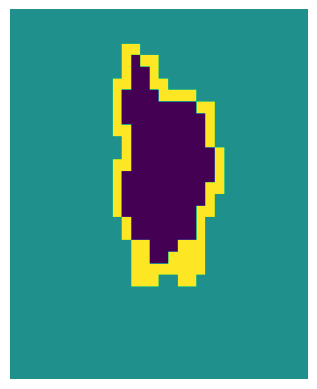

In [27]:
plt.imshow(pred_mask_resized.numpy())
plt.axis("off")
